In [1]:
#import package
using CSV, DataFrames
using Optim
using Plots
include("../src/ARCHModels.jl")
using .ARCHModels

In [45]:
# load data
tickers = ["SPY","KO","AAPL","TSLA","JNJ","CVX"]
ticker = tickers[3] # Choose ticker 
filename = ticker*"_RMs.csv"#
readpath = dirname(pwd())*"\\src\\data\\"*filename
df = DataFrame(CSV.File(readpath,header = 1))

,Column1,RV_15s,RV_2min,RV_5min,RV_10min,RV_15min,DR
,Date,Float64,Float64,Float64,Float64,Float64,Float64
1,2015-01-02,0.000271722,0.000302087,0.000410754,0.000280662,0.000428922,0.037661
2,2015-01-05,0.000389723,0.000354777,0.000357601,0.000367553,0.000229867,0.0301822
3,2015-01-06,0.000400819,0.000371405,0.000474523,0.000485154,0.000540384,0.0263161
4,2015-01-07,0.00031079,0.000267696,0.000219758,0.000197688,0.000230143,0.0139146
5,2015-01-08,0.000618023,0.000269749,0.000268532,0.000351997,0.000466789,0.0311995
6,2015-01-09,0.000276135,0.000315537,0.00028727,0.000234932,0.000464862,0.0272101
7,2015-01-12,0.000282548,0.000252561,0.000255396,0.000225432,0.000246084,0.034508
8,2015-01-13,0.000597722,0.00072058,0.000776164,0.00068122,0.000886172,0.0350945
9,2015-01-14,0.000374294,0.000331054,0.000300352,0.00021645,0.000197254,0.0180827


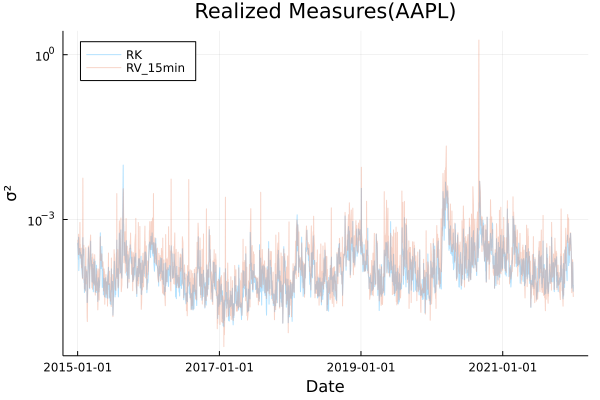

In [46]:
#Plot realized measures
plot(df[:,1],df[:,"RK"],title="Realized Measures("*ticker*")",yaxis=:log,alpha=0.3,label="RK",ylabel="σ²",legend=:topleft,xlabel="Date")
plot!(df[:,1],df[:,"RV_15min"],alpha=0.3,label="RV_15min")


In [66]:
#Estimate model

rms = ["RV_15s","RV_2min","RV_5min","RV_10min","RV_15min","DR","RK"]


# set insample size
N₁ = 1000

# daily return
c2c_r = diff(log.(df.close))
rt = c2c_r

#Out-of-sample unbiased daily variance 
σt2 = c2c_r[N₁+1:end].^2 .+0.00001 # 1 day squared return
#σt2 = df[N₁+2:end,"RV_15min"] # 15min RV
rt_N₁ = rt[1:N₁]

QLIKE = Dict()
fitted_coefs = Dict()
fitted_coefs["Parameter"] = ["ω","β","τ₁","τ₂","γ","ξ","δ₁","δ₂"]

for rm0 in rms
    rm = df[2:end,rm0]
    xt = rm
    xt_N₁ = rm[1:N₁]

    spec = RealGARCH{1,1}(zeros(8)) # RealGARCH{p,q} = pRealGARCH{p,q₁,q₂,S} where q₁=q₂ 

    am = UnivariateARCHXModel(spec,rt_N₁,xt_N₁)

    fitted_am = fit(am);
    fitted_coefs[rm0] = fitted_am.spec.coefs

    spec = RealGARCH{1,1}(fitted_coefs[rm0])
    am = UnivariateARCHXModel(spec,rt,xt)

    ht_realgarch_os = (volatilities(am).^2)[N₁+1:end]
    
    QLIKE[rm0] = [qlike(σt2,ht_realgarch_os)]
end


Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.459090e+06              NaN
 * time: 0.0


   500    -3.993034e+03     8.213172e-01
 * time: 0.0279998779296875


  1000    -4.004832e+03     1.653789e-02
 * time: 0.05799984931945801


Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.459090e+06              NaN
 * time: 0.0


   500    -4.281517e+03     2.215069e-02
 * time: 0.03000020980834961


  1000    -4.357708e+03     1.680800e-03
 * time: 0.06300020217895508


Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.459090e+06              NaN


 * time: 0.0
   500    -4.278454e+03     8.297052e-02


 * time: 0.028999805450439453
Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.459090e+06              NaN
 * time: 0.0


   500    -4.101960e+03     5.734282e-01
 * time: 0.029999971389770508


  1000    -4.170353e+03     1.442680e+00
 * time: 0.05900001525878906
Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.459090e+06              NaN
 * time: 0.0


   500    -3.931316e+03     4.013654e-01
 * time: 0.026999950408935547


  1000    -4.125333e+03     2.672125e+00
 * time: 0.05499982833862305
Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.459089e+06              NaN
 * time: 0.0


   500    -3.507954e+03     3.424400e+00
 * time: 0.029000043869018555


  1000    -4.099736e+03     3.631148e+00
 * time: 0.0559999942779541


Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.459090e+06              NaN
 * time: 0.0


   500    -4.177018e+03     8.705694e-02
 * time: 0.029000043869018555


  1000    -4.392421e+03     9.193621e-02
 * time: 0.056999921798706055


In [59]:
#QLIKE table
QLIKE_table = DataFrame(QLIKE)[:,rms]


,RV_15s,RV_2min,RV_5min,RV_10min,RV_15min,DR,RK
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,9.20122,7.01693,7.04154,7.63334,7.82695,8.72233,6.77223


In [68]:
#Relative QLIKE table (QLIKE of RealGARCH normalized to 1)
relative_QLIKE_table = QLIKE_table ./ QLIKE_table[1,"RK"]

,RV_15s,RV_2min,RV_5min,RV_10min,RV_15min,DR,RK
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.35288,1.03555,1.03903,1.12472,1.15248,1.28196,1.0


In [69]:
coef_tables = DataFrame(fitted_coefs)
coef_tables = coef_tables[:,["Parameter","RV_15s","RV_2min","RV_5min","RV_10min","RV_15min","DR","RK"]]
show(coef_tables,allcols=true)

8×8 DataFrame
 Row │ Parameter  RV_15s      RV_2min     RV_5min     RV_10min    RV_15min    DR          RK         
     │ String     Float64     Float64     Float64     Float64     Float64     Float64     Float64    
─────┼───────────────────────────────────────────────────────────────────────────────────────────────
   1 │ ω          -0.813222   -1.07675    -1.19222    -1.17409    -1.17832    -0.689332   -1.06823
   2 │ β           0.903878    0.873016    0.859593    0.861431    0.86085     0.91839     0.874076
   3 │ τ₁         -0.149179   -0.157561   -0.153493   -0.170329   -0.17203    -0.0562407  -0.139005
   4 │ τ₂          0.0422256   0.0568713   0.0614262   0.0504923   0.0497416   0.0427872   0.0595993
   5 │ γ           0.177468    0.334803    0.322668    0.235706    0.211367    0.118896    0.387339
   6 │ ξ          -0.142154   -0.413142   -0.449204   -0.517748   -0.546033    4.58104    -0.769058
   7 │ δ₁         -0.122301   -0.0965702  -0.0854806  -0.0935368  -0.0717177  -0